In [1]:
# -*- coding: utf-8 -*-
from __future__ import division
import argparse
import bz2
from datetime import datetime
import os
import pickle
from logger import Logger

import atari_py
import numpy as np
import torch
from tqdm import trange

from agent import Agent
from env import Env
from sunrise_memory import ReplayMemory
from test import ensemble_test
from tqdm import tqdm

In [2]:
class DataObject:
    def __init__(self):
        self.seed = 123
        self.game = 'boxing'
        self.T_max = 100000
        self.num_ensemble = 5
        self.beta_mean = 0.5
        self.memory_capacity = 500000
        self.id = 'vae_sunrise'
        self.temperature = 10
        self.learn_start = 1600
        self.target_update = 2000
        self.replay_frequency = 1
        self.multi_step = 20
        self.discount = 0.99
        self.architecture = 'data-efficient'
        self.max_episode_length = int(108e3)
        self.history_length = 4
        self.atoms = 51
        self.V_min = -10
        self.V_max = 10
        self.batch_size = 32
        self.model = None
        self.hidden_size = 256
        self.noisy_std = 0.1
        self.evaluation_size = 12000
        self.learning_rate = 0.0001
        self.adam_eps = 1.5e-4
        self.priority_weight = 0.4
        self.priority_exponent = 0.5
        
        if torch.cuda.is_available():
            self.device = torch.device('cuda')
            torch.cuda.manual_seed(np.random.randint(1, 10000))
            torch.backends.cudnn.enabled = True
            torch.set_default_tensor_type('torch.FloatTensor')

In [3]:
args = DataObject()

In [155]:
# Environment
env = Env(args)
env.train()
action_space = env.action_space()

# Agent
dqn_list = []
for _ in range(args.num_ensemble):
    dqn = Agent(args, env)
    dqn_list.append(dqn)

# If a model is provided, and evaluate is fale, presumably we want to resume, so try to load memory
if args.model is not None and not args.evaluate:
    if not args.memory:
        raise ValueError('Cannot resume training without memory save path. Aborting...')
    elif not os.path.exists(args.memory):
        raise ValueError('Could not find memory file at {path}. Aborting...'.format(path=args.memory))
    mem = load_memory(args.memory, args.disable_bzip_memory)

else:
    mem = ReplayMemory(args, args.memory_capacity, args.beta_mean, args.num_ensemble)

priority_weight_increase = (1 - args.priority_weight) / (args.T_max - args.learn_start)

# Construct validation memory
val_mem = ReplayMemory(args, args.evaluation_size, args.beta_mean, args.num_ensemble)
T, done = 0, True
state_list = []
for i in tqdm(range(args.evaluation_size)):
    if done:
        state, done = env.reset(), False
    if i>5:
        next_state, _, done = env.step(np.random.randint(0, action_space))
        val_mem.append(state, 0, 0, done)
        state = next_state
        state_list.append(state)
        T += 1

100%|██████████| 12000/12000 [00:23<00:00, 515.16it/s]


In [8]:
torch.nn.Conv2d(6, 6, 2, stride=1)

Conv2d(6, 6, kernel_size=(2, 2), stride=(1, 1))

In [117]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt


class Normal(object):
    def __init__(self, mu, sigma, log_sigma, v=None, r=None):
        self.mu = mu
        self.sigma = sigma  # either stdev diagonal itself, or stdev diagonal from decomposition
        self.logsigma = log_sigma
        dim = mu.get_shape()
        if v is None:
            v = torch.FloatTensor(*dim)
            if r is None:
                r = torch.FloatTensor(*dim)
                self.v = v
                self.r = r
                
class Encoder(torch.nn.Module):
    def __init__(self, H, D_out):
        super(Encoder, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 4, 3, stride=1)
        self.linear1 = torch.nn.Linear(48, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.linear1(x))
        return F.relu(self.linear2(x))
    
    
class Decoder(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Decoder, self).__init__()
        self.conv1 = torch.nn.ConvTranspose2d(4, 1, 3, stride=1)
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, 48)
    
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        return F.relu(self.conv1(x))
    
class VAE(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.latent_dim = 64
        self.encoder = encoder
        self.decoder = decoder
        self._enc_mu = torch.nn.Linear(1000, self.latent_dim)
        self._enc_log_sigma = torch.nn.Linear(1000, self.latent_dim)
    
    def _sample_latent(self, h_enc):
        """
        Return the latent normal sample z ~ N(mu, sigma^2)
        """
        mu = self._enc_mu(h_enc)
        log_sigma = self._enc_log_sigma(h_enc)
        sigma = torch.exp(log_sigma)
        std_z = torch.from_numpy(np.random.normal(0, 1, size=sigma.size())).float()
        
        self.z_mean = mu
        self.z_sigma = sigma
        return mu + sigma * Variable(std_z, requires_grad=False)  # Reparameterization trick
    
    def forward(self, state):
        h_enc = self.encoder(state)
        z = self._sample_latent(h_enc)
        return self.decoder(z)
    
def latent_loss(z_mean, z_stddev):
    mean_sq = z_mean * z_mean
    stddev_sq = z_stddev * z_stddev
    return 0.5 * torch.mean(mean_sq + stddev_sq - torch.log(stddev_sq) - 1)

# input_dim = 57 * 50
batch_size = 32
encoder = Encoder(1000, 1000)
decoder = Decoder(64, 1000, input_dim)
vae = VAE(encoder, decoder)
criterion = nn.MSELoss()

optimizer = optim.Adam(vae.parameters(), lr=0.001)
l = None
for epoch in tqdm(range(1000)):
    idxs, states, actions, returns, next_states, nonterminals, weights, masks = val_mem.sample(32)
    inputs =  Variable(states[:,0,14:-13,17:-17].reshape((32,1,57,50)).cpu())
    optimizer.zero_grad()
    dec = vae(inputs)
    ll = latent_loss(vae.z_mean, vae.z_sigma)
    loss = criterion(dec, inputs) + ll
    loss.backward()
    optimizer.step()
    l = loss.item()
    
    print(epoch, l)
    
plt.imshow(vae(inputs).data[0].numpy().reshape(57, 50), cmap='gray')
plt.show(block=True)

  0%|          | 1/1000 [00:01<21:06,  1.27s/it]

0 0.27090778946876526


  0%|          | 2/1000 [00:02<21:22,  1.29s/it]

1 0.2621576488018036


  0%|          | 3/1000 [00:03<21:18,  1.28s/it]

2 0.2483266144990921


  0%|          | 4/1000 [00:05<20:56,  1.26s/it]

3 0.23289690911769867


  0%|          | 5/1000 [00:06<20:26,  1.23s/it]

4 0.22158931195735931


  1%|          | 6/1000 [00:07<20:01,  1.21s/it]

5 0.2167484313249588


  1%|          | 7/1000 [00:08<19:59,  1.21s/it]

6 0.214602530002594


  1%|          | 8/1000 [00:09<20:41,  1.25s/it]

7 0.2108871340751648


  1%|          | 9/1000 [00:11<21:02,  1.27s/it]

8 0.2070579081773758


  1%|          | 10/1000 [00:12<21:08,  1.28s/it]

9 0.2011612206697464


  1%|          | 11/1000 [00:13<20:37,  1.25s/it]

10 0.20217183232307434


  1%|          | 12/1000 [00:14<20:14,  1.23s/it]

11 0.19872088730335236


  1%|▏         | 13/1000 [00:16<20:57,  1.27s/it]

12 0.1963682323694229


  1%|▏         | 14/1000 [00:17<21:22,  1.30s/it]

13 0.19527801871299744


  2%|▏         | 15/1000 [00:18<20:55,  1.27s/it]

14 0.1934392750263214


  2%|▏         | 16/1000 [00:20<20:19,  1.24s/it]

15 0.19337749481201172


  2%|▏         | 17/1000 [00:21<20:09,  1.23s/it]

16 0.18953414261341095


  2%|▏         | 18/1000 [00:22<20:29,  1.25s/it]

17 0.18665120005607605


  2%|▏         | 19/1000 [00:23<20:09,  1.23s/it]

18 0.18355858325958252


  2%|▏         | 20/1000 [00:24<19:45,  1.21s/it]

19 0.18195848166942596


  2%|▏         | 21/1000 [00:26<19:55,  1.22s/it]

20 0.18144166469573975


  2%|▏         | 22/1000 [00:27<19:54,  1.22s/it]

21 0.17967815697193146


  2%|▏         | 23/1000 [00:28<20:06,  1.23s/it]

22 0.17648105323314667


  2%|▏         | 24/1000 [00:29<19:55,  1.22s/it]

23 0.17707109451293945


  2%|▎         | 25/1000 [00:31<20:27,  1.26s/it]

24 0.17693984508514404


  3%|▎         | 26/1000 [00:32<20:40,  1.27s/it]

25 0.1762792468070984


  3%|▎         | 27/1000 [00:33<20:22,  1.26s/it]

26 0.1751604974269867


  3%|▎         | 28/1000 [00:34<20:27,  1.26s/it]

27 0.17444898188114166


  3%|▎         | 29/1000 [00:36<20:23,  1.26s/it]

28 0.17282642424106598


  3%|▎         | 30/1000 [00:37<19:48,  1.22s/it]

29 0.17251700162887573


  3%|▎         | 31/1000 [00:38<19:52,  1.23s/it]

30 0.17180344462394714


  3%|▎         | 32/1000 [00:39<19:52,  1.23s/it]

31 0.17143230140209198


  3%|▎         | 33/1000 [00:41<20:06,  1.25s/it]

32 0.1715976446866989


  3%|▎         | 34/1000 [00:42<20:10,  1.25s/it]

33 0.17078469693660736


  4%|▎         | 35/1000 [00:43<20:18,  1.26s/it]

34 0.17034612596035004


  4%|▎         | 36/1000 [00:44<19:55,  1.24s/it]

35 0.16960062086582184


  4%|▎         | 37/1000 [00:46<20:04,  1.25s/it]

36 0.16922453045845032


  4%|▍         | 38/1000 [00:47<20:07,  1.25s/it]

37 0.16873733699321747


  4%|▍         | 39/1000 [00:48<20:04,  1.25s/it]

38 0.168615460395813


  4%|▍         | 40/1000 [00:49<19:26,  1.21s/it]

39 0.16792672872543335


  4%|▍         | 41/1000 [00:50<18:48,  1.18s/it]

40 0.16765977442264557


  4%|▍         | 42/1000 [00:52<18:57,  1.19s/it]

41 0.16757196187973022


  4%|▍         | 43/1000 [00:53<19:03,  1.20s/it]

42 0.16655723750591278


  4%|▍         | 44/1000 [00:54<19:22,  1.22s/it]

43 0.16690897941589355


  4%|▍         | 45/1000 [00:55<19:11,  1.21s/it]

44 0.1664460003376007


  5%|▍         | 46/1000 [00:56<18:36,  1.17s/it]

45 0.1666816622018814


  5%|▍         | 47/1000 [00:57<18:26,  1.16s/it]

46 0.16616833209991455


  5%|▍         | 48/1000 [00:59<18:34,  1.17s/it]

47 0.16576124727725983


  5%|▍         | 49/1000 [01:00<18:05,  1.14s/it]

48 0.16593442857265472


  5%|▌         | 50/1000 [01:01<18:16,  1.15s/it]

49 0.1654030680656433


  5%|▌         | 51/1000 [01:02<18:38,  1.18s/it]

50 0.16577409207820892


  5%|▌         | 52/1000 [01:04<19:45,  1.25s/it]

51 0.16520138084888458


  5%|▌         | 53/1000 [01:05<19:35,  1.24s/it]

52 0.16533207893371582


  5%|▌         | 54/1000 [01:06<19:27,  1.23s/it]

53 0.16523849964141846


  6%|▌         | 55/1000 [01:07<19:54,  1.26s/it]

54 0.1652461141347885


  6%|▌         | 56/1000 [01:09<20:22,  1.29s/it]

55 0.1645394265651703


  6%|▌         | 57/1000 [01:10<19:52,  1.26s/it]

56 0.16416466236114502


  6%|▌         | 58/1000 [01:11<19:46,  1.26s/it]

57 0.1644783467054367


  6%|▌         | 59/1000 [01:12<19:56,  1.27s/it]

58 0.16437362134456635


  6%|▌         | 60/1000 [01:14<19:50,  1.27s/it]

59 0.16280041635036469


  6%|▌         | 61/1000 [01:15<19:28,  1.24s/it]

60 0.1647251546382904


  6%|▌         | 62/1000 [01:16<19:07,  1.22s/it]

61 0.16399718821048737


  6%|▋         | 63/1000 [01:17<18:39,  1.20s/it]

62 0.16425363719463348


  6%|▋         | 64/1000 [01:18<18:08,  1.16s/it]

63 0.16409046947956085


  6%|▋         | 65/1000 [01:19<18:14,  1.17s/it]

64 0.16408972442150116


  7%|▋         | 66/1000 [01:21<18:57,  1.22s/it]

65 0.16324947774410248


  7%|▋         | 67/1000 [01:22<18:34,  1.19s/it]

66 0.16401079297065735


  7%|▋         | 68/1000 [01:23<18:46,  1.21s/it]

67 0.16353419423103333


  7%|▋         | 69/1000 [01:25<19:22,  1.25s/it]

68 0.16378483176231384


  7%|▋         | 70/1000 [01:26<19:26,  1.25s/it]

69 0.16384141147136688


  7%|▋         | 71/1000 [01:27<18:53,  1.22s/it]

70 0.1630840003490448


  7%|▋         | 72/1000 [01:28<18:59,  1.23s/it]

71 0.16326160728931427


  7%|▋         | 73/1000 [01:29<18:50,  1.22s/it]

72 0.16344785690307617


  7%|▋         | 74/1000 [01:31<19:04,  1.24s/it]

73 0.16172824800014496


  8%|▊         | 75/1000 [01:32<19:08,  1.24s/it]

74 0.16308142244815826


  8%|▊         | 76/1000 [01:33<18:36,  1.21s/it]

75 0.16321143507957458


  8%|▊         | 77/1000 [01:34<17:27,  1.13s/it]

76 0.16325126588344574


  8%|▊         | 78/1000 [01:35<17:34,  1.14s/it]

77 0.16311602294445038


  8%|▊         | 79/1000 [01:36<17:49,  1.16s/it]

78 0.16344456374645233


  8%|▊         | 80/1000 [01:38<18:23,  1.20s/it]

79 0.16285103559494019


  8%|▊         | 81/1000 [01:39<18:07,  1.18s/it]

80 0.1630764901638031


  8%|▊         | 82/1000 [01:40<17:45,  1.16s/it]

81 0.1630237102508545


  8%|▊         | 83/1000 [01:41<16:39,  1.09s/it]

82 0.16255244612693787


  8%|▊         | 83/1000 [01:42<18:53,  1.24s/it]


KeyboardInterrupt: 

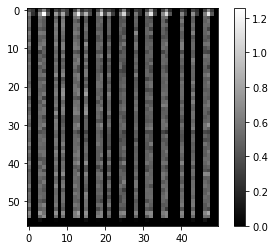

In [118]:
plt.imshow(vae(inputs).data[0].numpy().reshape(57, 50), cmap='gray')
plt.colorbar()

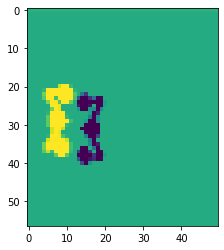

In [115]:
plt.imshow(inputs.data[1].numpy().reshape(57,50))

In [ ]:
plt.imshow(vae(inputs).data[15].numpy().reshape(57, 50), cmap='gray')
plt.colorbar()

In [ ]:
plt.imshow(inputs.data[15].numpy().reshape(57,50))

In [ ]:
plt.imshow(inputs.data[20].numpy().reshape(57,50))

In [ ]:
plt.plot(vae.encoder(inputs).data[30].numpy())

In [ ]:
plt.imshow(inputs.data[10].numpy().reshape(57,50))

In [ ]:
plt.plot(vae.encoder(inputs).data[10].numpy()-vae.encoder(inputs).data[30].numpy())

In [ ]:
h_enc = vae.encoder(inputs)
latent = vae._sample_latent(h_enc).cpu().detach().numpy()

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
embed = TSNE(perplexity=5)
tsne_embedding = embed.fit_transform(latent)
plt.scatter(tsne_embedding[:,0], tsne_embedding[:,1])

In [ ]:
points = tsne_embedding
plt.figure(figsize=(10,10))

for i in range(len(points)):
    x = points[i][0]
    y = points[i][1]
    plt.plot(x, y, 'bo')
    plt.text(x * (1 + 0.01), y * (1 + 0.01) , i, fontsize=12)

In [ ]:
plt.imshow(inputs.data[16].numpy().reshape(57,50))

In [ ]:
plt.imshow(inputs.data[14].numpy().reshape(57,50))

In [ ]:
plt.imshow(inputs.data[5].numpy().reshape(57,50))

# PCA Attempt

In [197]:
total_dataset = []

for state in state_list:
    check = state.cpu().detach().numpy()
    if check==0:
        total_dataset.append(check)

In [199]:
total_dataset = np.array(total_dataset)

In [200]:
total_dataset.shape

(11994, 4, 84, 84)

In [158]:
reshaped_dataset = np.reshape(total_dataset[:6000,0,:,:],(6000,84*84))

In [159]:
from sklearn.decomposition import PCA

In [160]:
pca_embed = PCA()

In [295]:
reshaped_dataset - reshaped_dataset.mean()

array([[-0.49400592, -0.49400592, -0.49400592, ..., -0.49400592,
        -0.49400592, -0.49400592],
       [-0.49400592, -0.49400592, -0.49400592, ..., -0.49400592,
        -0.49400592, -0.49400592],
       [-0.49400592, -0.49400592, -0.49400592, ...,  0.02364117,
         0.02364117,  0.02364117],
       ...,
       [-0.49400592, -0.49400592, -0.49400592, ...,  0.02364117,
         0.02364117,  0.02364117],
       [-0.49400592, -0.49400592, -0.49400592, ...,  0.02364117,
         0.02364117,  0.02364117],
       [-0.49400592, -0.49400592, -0.49400592, ...,  0.02364117,
         0.02364117,  0.02364117]], dtype=float32)

In [296]:
pca_embed.fit(reshaped_dataset)

PCA()

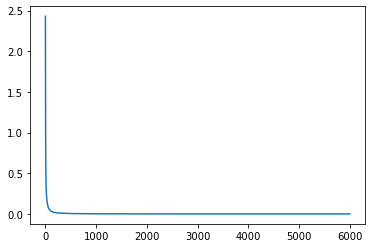

In [297]:
plt.plot(pca_embed.explained_variance_)

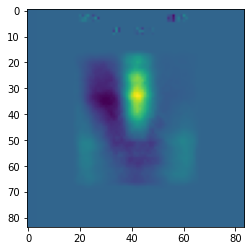

In [351]:
plt.imshow(np.reshape(pca_embed.components_[2], (84,84)))

In [164]:
results = pca_embed.transform(reshaped_dataset)

In [284]:
reshaped_dataset.shape

(6000, 7056)

In [165]:
results.shape

(6000, 6000)

In [166]:
reprojected_images = np.dot(results[:,2:100], pca_embed.components_[2:100])

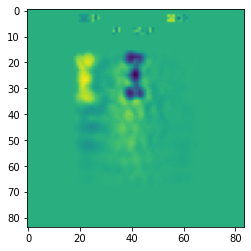

In [167]:
plt.imshow(np.reshape(reprojected_images[20], (84,84)))

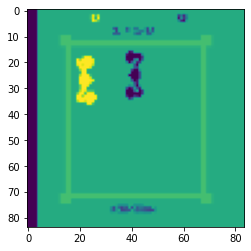

In [168]:
plt.imshow(total_dataset[20,0])

In [169]:
from sklearn.manifold import TSNE

In [170]:
embed = TSNE()

In [171]:
tsne_embedding = embed.fit_transform(results[:300,:100])

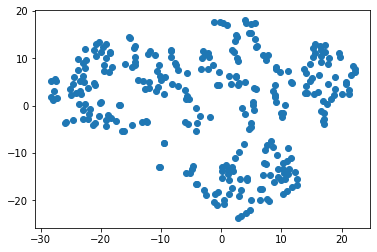

In [172]:
plt.scatter(tsne_embedding[:,0], tsne_embedding[:,1])

In [173]:
mask = np.logical_and((tsne_embedding[:,0]>20),(tsne_embedding[:,1]>20))

In [174]:
check = total_dataset[:300][mask]

In [175]:
for im in check[:20,0,:,:]:
    plt.figure()
    plt.imshow(im)

In [176]:
from sklearn.cluster import KMeans

In [263]:
clusterer = KMeans(n_clusters=5)

In [264]:
clusterer.fit(results[keep_mask,:100])

KMeans(n_clusters=5)

In [265]:
labels = clusterer.predict(results[keep_mask,:100])

In [266]:
tsne_embedding = embed.fit_transform(results[keep_mask,:100])

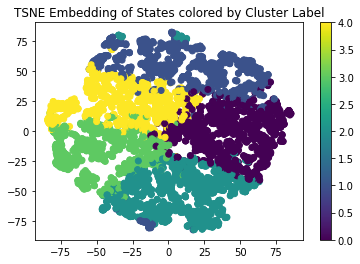

In [352]:
plt.title("TSNE Embedding of States colored by Cluster Label")
plt.scatter(tsne_embedding[:,0], tsne_embedding[:,1],c=labels)
plt.colorbar()

In [258]:
np.sum(labels==0)

3285

In [277]:
np.sum(labels==1)

1209

In [278]:
np.sum(labels==2)

1384

In [279]:
np.sum(labels==3)

987

In [280]:
np.sum(labels==4)

1094

In [261]:
keep_mask = labels!=1

In [260]:
np.sum(labels==2)

2707

In [238]:
keep_mask = labels!=2

In [239]:
np.sum(labels==3)

0

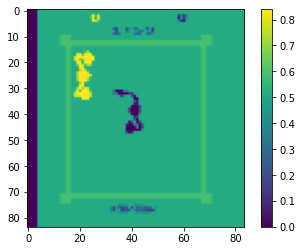

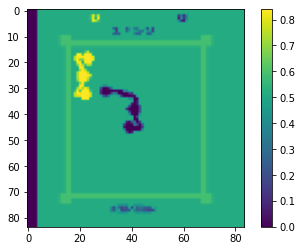

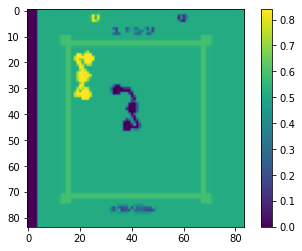

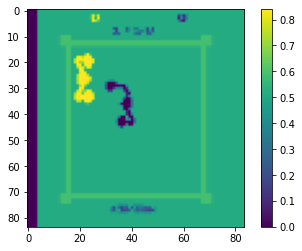

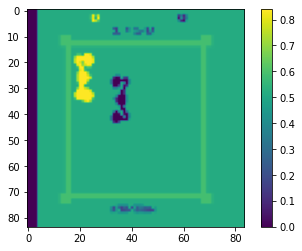

In [268]:
for i in range(20):
    if labels[i]==1:
        plt.figure()
        plt.imshow(total_dataset[i,0])
        plt.colorbar()

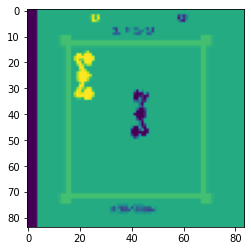

In [276]:
for i in range(100):
    if labels[i]==4:
        plt.figure()
        plt.imshow(total_dataset[i,0])

In [306]:
centers = np.array(clusterer.cluster_centers_)

 ## Pickling

In [286]:
import pickle as pk

In [288]:
pk.dump(pca_embed, open("pca.pkl",'wb'))

In [308]:
np.save('centers',centers)

# Open

In [310]:
open_check = np.load('centers.npy')

In [312]:
open_check

(5, 100)

In [314]:
encoder = pk.load(open("pca.pkl",'rb'))

In [325]:
state_list[0].cpu().detach().numpy().sum(axis=0).ravel()

array([0.       , 0.       , 0.       , ..., 1.0352942, 1.0352942,
       1.0352942], dtype=float32)

In [340]:
encoded_obs = encoder.transform(np.reshape(state_list[30].cpu().detach().numpy().sum(axis=0).ravel(),(1,84*84)))

In [345]:
dists = np.array([np.linalg.norm(encoded_obs[0,:100] - cen) for cen in open_check])

In [346]:
dists - dists.mean()

array([-0.1278534 , -0.03149414,  0.0743103 ,  0.06884766,  0.01622009],
      dtype=float32)

In [347]:
from scipy.special import softmax

In [349]:
softmax(dists - dists.mean())

array([0.17551397, 0.19326803, 0.2148376 , 0.21366721, 0.20271319],
      dtype=float32)

# CNN + VAE

In [ ]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt


class Normal(object):
    def __init__(self, mu, sigma, log_sigma, v=None, r=None):
        self.mu = mu
        self.sigma = sigma  # either stdev diagonal itself, or stdev diagonal from decomposition
        self.logsigma = log_sigma
        dim = mu.get_shape()
        if v is None:
            v = torch.FloatTensor(*dim)
            if r is None:
                r = torch.FloatTensor(*dim)
                self.v = v
                self.r = r
                
                
class Encoder(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Encoder, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        return F.relu(self.linear2(x))
    
    
class Decoder(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Decoder, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)
    
    def forward(self, x):
        x = F.relu(self.linear1(x))
        return F.relu(self.linear2(x))
    
class VAE(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.latent_dim = 64
        self.encoder = encoder
        self.decoder = decoder
        self._enc_mu = torch.nn.Linear(1000, self.latent_dim)
        self._enc_log_sigma = torch.nn.Linear(1000, self.latent_dim)
    
    def _sample_latent(self, h_enc):
        """
        Return the latent normal sample z ~ N(mu, sigma^2)
        """
        mu = self._enc_mu(h_enc)
        log_sigma = self._enc_log_sigma(h_enc)
        sigma = torch.exp(log_sigma)
        std_z = torch.from_numpy(np.random.normal(0, 1, size=sigma.size())).float()
        
        self.z_mean = mu
        self.z_sigma = sigma
        return mu + sigma * Variable(std_z, requires_grad=False)  # Reparameterization trick
    
    def forward(self, state):
        h_enc = self.encoder(state)
        z = self._sample_latent(h_enc)
        return self.decoder(z)
    
    def latent_loss(z_mean, z_stddev):
        mean_sq = z_mean * z_mean
        stddev_sq = z_stddev * z_stddev
        return 0.5 * torch.mean(mean_sq + stddev_sq - torch.log(stddev_sq) - 1)

input_dim = 57 * 50
batch_size = 32
encoder = Encoder(input_dim, 1000, 1000)
decoder = Decoder(64, 1000, input_dim)
vae = VAE(encoder, decoder)
criterion = nn.MSELoss()

optimizer = optim.Adam(vae.parameters(), lr=0.001)
l = None
for epoch in tqdm(range(6000)):
    idxs, states, actions, returns, next_states, nonterminals, weights, masks = val_mem.sample(32)
    inputs =  Variable(states[:,:,14:-13,17:-17].reshape((32*4,57*50)).cpu())
    optimizer.zero_grad()
    dec = vae(inputs)
    ll = latent_loss(vae.z_mean, vae.z_sigma)
    loss = criterion(dec, inputs) + ll
    loss.backward()
    optimizer.step()
    l = loss.item()
    
    print(epoch, l)
    
plt.imshow(vae(inputs).data[0].numpy().reshape(57, 50), cmap='gray')
plt.show(block=True)